In [17]:
print(y.value_counts(normalize=True))


churn_numeric
0    0.73463
1    0.26537
Name: proportion, dtype: float64


Rows, columns: (7043, 50)
Sample data:
  Customer ID  Gender  Age Under 30 Senior Citizen Married Dependents  \
0  8779-QRDMV    Male   78       No            Yes      No         No   
1  7495-OOKFY  Female   74       No            Yes     Yes        Yes   
2  1658-BYGOY    Male   71       No            Yes      No        Yes   

   Number of Dependents        Country       State  ...  \
0                     0  United States  California  ...   
1                     1  United States  California  ...   
2                     3  United States  California  ...   

  Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
0                       20                         0.00          59.65   
1                        0                       390.80        1024.10   
2                        0                       203.94        1910.88   

   Satisfaction Score  Customer Status Churn Label Churn Score  CLTV  \
0                   3          Churned         Yes          91

C:\Windows\System32\config\systemprofile\AppData\Local\Temp\ipykernel_39568\3351752492.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn_numeric', data=df_model, palette="Set2")


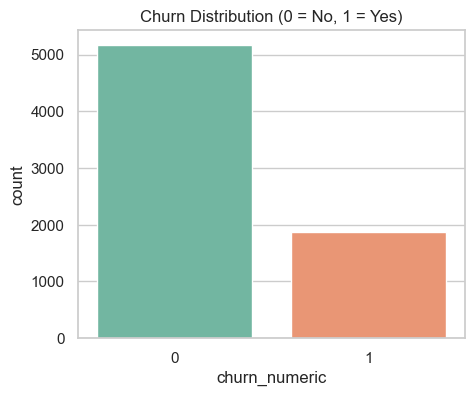

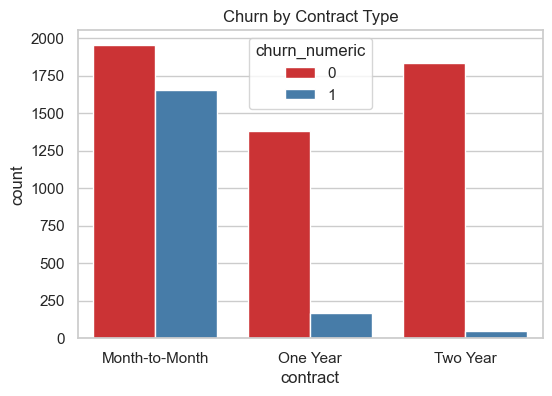

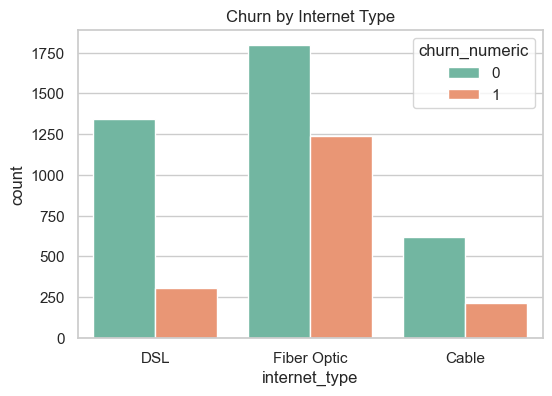

C:\Windows\System32\config\systemprofile\AppData\Local\Temp\ipykernel_39568\3351752492.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn_numeric', y='satisfaction_score', data=df_model, palette="coolwarm")


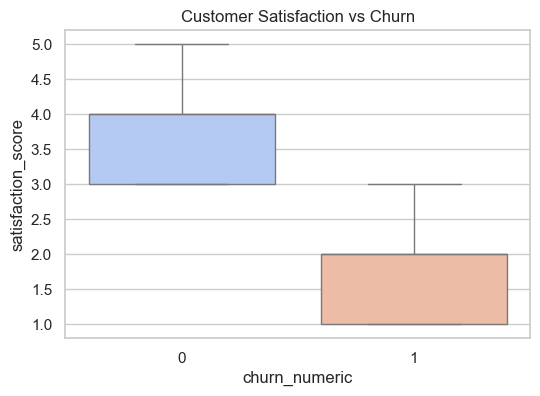

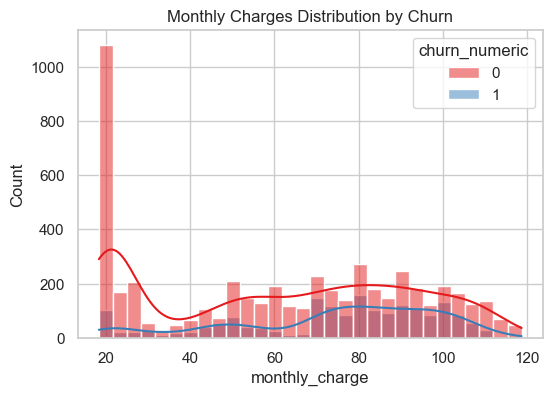

Numeric features: ['age', 'number_of_dependents', 'population', 'number_of_referrals', 'tenure_in_months', 'avg_monthly_long_distance_charges', 'avg_monthly_gb_download', 'monthly_charge', 'total_charges', 'total_refunds']
Categorical features: ['gender', 'under_30', 'senior_citizen', 'married', 'dependents', 'country', 'state', 'city', 'quarter', 'referred_a_friend']
Train shape: (5634, 41) Test shape: (1409, 41)
Model trained.
Accuracy: 0.9510290986515259

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1035
           1       0.89      0.93      0.91       374

    accuracy                           0.95      1409
   macro avg       0.93      0.94      0.94      1409
weighted avg       0.95      0.95      0.95      1409



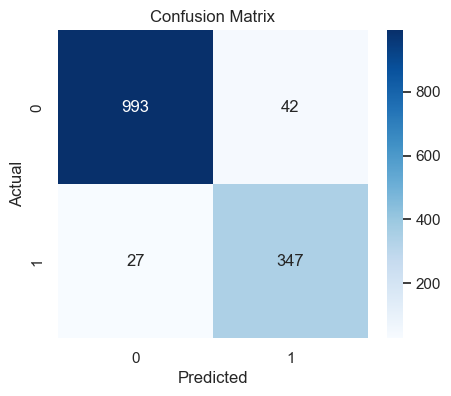

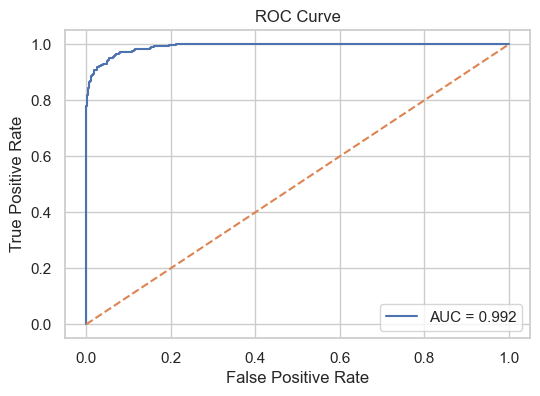

ROC AUC: 0.9915446020305356
Top churn drivers:
                                feature  coefficient
606   cat__city_March Air Reserve Base     1.731431
879                cat__city_San Diego     1.655094
918               cat__city_Santa Rosa     1.499934
727                  cat__city_Ontario     1.473790
725               cat__city_Olivehurst     1.461185
342                cat__city_Fallbrook     1.414436
135                     cat__city_Brea     1.391534
1102                 cat__city_Willows     1.296087
243                  cat__city_Corning     1.277743
1150           cat__online_security_No     1.274249

Top retention drivers:
                         feature  coefficient
82        cat__city_Bakersfield    -0.787391
158   cat__city_California City    -0.828335
647           cat__city_Modesto    -0.902079
1020    cat__city_Thousand Oaks    -0.918766
1168     cat__contract_Two Year    -0.952640
728            cat__city_Orange    -1.154742
24          cat__dependents_Yes    -1.28

In [4]:
# ======================
# Step 1 — Imports
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

import joblib

sns.set(style="whitegrid")

# ======================
# Step 2 — Load Data
# ======================
df = pd.read_csv("telco.csv")

print("Rows, columns:", df.shape)
print("Sample data:")
print(df.head(3))

# ======================
# Step 3 — Clean Column Names
# ======================
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(' ', '_', regex=True)
      .str.replace(r'[^\w]', '', regex=True)
)

print("Cleaned column names:", df.columns.tolist()[:10])

# ======================
# Step 4 — Create Target Variable
# ======================
df['churn_numeric'] = df['churn_label'].map({'Yes': 1, 'No': 0})
print(df['churn_numeric'].value_counts(normalize=True))

# ======================
# Step 5 — Drop Irrelevant Columns
# ======================
drop_cols = [
    'customer_id', 'zip_code', 'latitude', 'longitude',
    'churn_label', 'customer_status', 'churn_score',
    'churn_category', 'churn_reason'
]

df_model = df.drop(columns=drop_cols, errors='ignore')
print("Model dataset shape:", df_model.shape)

# ======================
# Step 5.1 — Exploratory Data Analysis (EDA)
# ======================

# 1. Churn distribution
plt.figure(figsize=(5,4))
sns.countplot(x='churn_numeric', data=df_model, palette="Set2")
plt.title("Churn Distribution (0 = No, 1 = Yes)")
plt.show()

# 2. Churn by Contract type
plt.figure(figsize=(6,4))
sns.countplot(x='contract', hue='churn_numeric', data=df_model, palette="Set1")
plt.title("Churn by Contract Type")
plt.show()

# 3. Churn by Internet type
plt.figure(figsize=(6,4))
sns.countplot(x='internet_type', hue='churn_numeric', data=df_model, palette="Set2")
plt.title("Churn by Internet Type")
plt.show()

# 4. Satisfaction Score vs Churn
plt.figure(figsize=(6,4))
sns.boxplot(x='churn_numeric', y='satisfaction_score', data=df_model, palette="coolwarm")
plt.title("Customer Satisfaction vs Churn")
plt.show()

# 5. Monthly Charge vs Churn
plt.figure(figsize=(6,4))
sns.histplot(data=df_model, x='monthly_charge', hue='churn_numeric', bins=30, kde=True, palette="Set1")
plt.title("Monthly Charges Distribution by Churn")
plt.show()

# ======================
# Step 6 — Split Features & Target
# ======================
X = df_model.drop(columns=['churn_numeric'])
y = df_model['churn_numeric']

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Numeric features:", numeric_features[:10])
print("Categorical features:", categorical_features[:10])

# ======================
# Step 7 — Train/Test Split
# ======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ======================
# Step 8 — Preprocessing + Logistic Regression Pipeline
# ======================
numeric_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ]
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

model_pipeline.fit(X_train, y_train)
print("Model trained.")

# ======================
# Step 9 — Model Evaluation
# ======================
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC AUC:", auc)

# ======================
# Step 10 — Feature Importance
# ======================
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefs = model_pipeline.named_steps['classifier'].coef_[0]

feat_imp = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})
feat_imp = feat_imp.sort_values(by='coefficient', ascending=False)

print("Top churn drivers:\n", feat_imp.head(10))
print("\nTop retention drivers:\n", feat_imp.tail(10))

# ======================
# Step 11 — Save Model
# ======================
joblib.dump(model_pipeline, "churn_model_pipeline.pkl")
print("Saved pipeline to churn_model_pipeline.pkl")

# ======================
# Step 12 — Predict on New Data
# ======================
sample = X_test.head(5)
preds = model_pipeline.predict(sample)
probs = model_pipeline.predict_proba(sample)[:, 1]

print("Predictions:", preds)
print("Churn probabilities:", np.round(probs, 3))
